<a href="https://colab.research.google.com/github/escuccim/faceswap/blob/master/FaceSwap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
import cv2
import numpy
import os
from google.colab import auth
import zipfile
from google.colab.patches import cv2_imshow

auth.authenticate_user()

# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'gan-faces'

!gcloud config set project {project_id}

Using TensorFlow backend.


Updated property [core/project].


In [11]:
if not os.path.exists("named_celebs_good2.zip"):  
  !gsutil cp gs://{bucket_name}/named_celebs_good2.zip ./named_celebs_good2.zip
  zip_ref = zipfile.ZipFile('named_celebs_good2.zip', 'r')
  zip_ref.extractall('data/images/named_images')
  zip_ref.close()

if not os.path.exists("models.zip"):  
  !gsutil cp gs://{bucket_name}/models.zip ./models.zip
  zip_ref = zipfile.ZipFile('models.zip', 'r')
  zip_ref.extractall('./')
  zip_ref.close()  

Copying gs://gan-faces/models.zip...
\ [1 files][290.2 MiB/290.2 MiB]                                                
Operation completed over 1 objects/290.2 MiB.                                    


In [0]:
def get_image_paths( directory ):
    return [ x.path for x in os.scandir( directory ) if x.name.endswith(".jpg") or x.name.endswith(".png") ]

def load_images( image_paths, convert=None ):
    iter_all_images = ( cv2.imread(fn) for fn in image_paths )
    if convert:
        iter_all_images = ( convert(img) for img in iter_all_images )
    for i,image in enumerate( iter_all_images ):
        image = cv2.resize(image, (107,107))
        if i == 0:
            all_images = numpy.empty( ( len(image_paths), ) + image.shape, dtype=image.dtype )
        all_images[i] = image
    return all_images

def get_transpose_axes( n ):
    if n % 2 == 0:
        y_axes = list( range( 1, n-1, 2 ) )
        x_axes = list( range( 0, n-1, 2 ) )
    else:
        y_axes = list( range( 0, n-1, 2 ) )
        x_axes = list( range( 1, n-1, 2 ) )
    return y_axes, x_axes, [n-1]

def stack_images( images ):
    images_shape = numpy.array( images.shape )
    new_axes = get_transpose_axes( len( images_shape ) )
    new_shape = [ numpy.prod( images_shape[x] ) for x in new_axes ]
    return numpy.transpose(
        images,
        axes = numpy.concatenate( new_axes )
        ).reshape( new_shape )

In [0]:
from keras.utils import conv_utils
from keras.engine.topology import Layer
import keras.backend as K

import keras.backend as K
def normalize_data_format(value):
    if value is None:
        value = K.image_data_format()
    data_format = value.lower()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('The `data_format` argument must be one of '
                         '"channels_first", "channels_last". Received: ' +
                         str(value))
    return data_format
    

class PixelShuffler(Layer):
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(PixelShuffler, self).__init__(**kwargs)
        self.data_format = normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')

    def call(self, inputs):

        input_shape = K.int_shape(inputs)
        if len(input_shape) != 4:
            raise ValueError('Inputs should have rank ' +
                             str(4) +
                             '; Received input shape:', str(input_shape))

        if self.data_format == 'channels_first':
            batch_size, c, h, w = input_shape
            if batch_size is None:
                batch_size = -1
            rh, rw = self.size
            oh, ow = h * rh, w * rw
            oc = c // (rh * rw)

            out = K.reshape(inputs, (batch_size, rh, rw, oc, h, w))
            out = K.permute_dimensions(out, (0, 3, 4, 1, 5, 2))
            out = K.reshape(out, (batch_size, oc, oh, ow))
            return out

        elif self.data_format == 'channels_last':
            batch_size, h, w, c = input_shape
            if batch_size is None:
                batch_size = -1
            rh, rw = self.size
            oh, ow = h * rh, w * rw
            oc = c // (rh * rw)

            out = K.reshape(inputs, (batch_size, h, w, rh, rw, oc))
            out = K.permute_dimensions(out, (0, 1, 3, 2, 4, 5))
            out = K.reshape(out, (batch_size, oh, ow, oc))
            return out

    def compute_output_shape(self, input_shape):

        if len(input_shape) != 4:
            raise ValueError('Inputs should have rank ' +
                             str(4) +
                             '; Received input shape:', str(input_shape))

        if self.data_format == 'channels_first':
            height = input_shape[2] * self.size[0] if input_shape[2] is not None else None
            width = input_shape[3] * self.size[1] if input_shape[3] is not None else None
            channels = input_shape[1] // self.size[0] // self.size[1]

            if channels * self.size[0] * self.size[1] != input_shape[1]:
                raise ValueError('channels of input and size are incompatible')

            return (input_shape[0],
                    channels,
                    height,
                    width)

        elif self.data_format == 'channels_last':
            height = input_shape[1] * self.size[0] if input_shape[1] is not None else None
            width = input_shape[2] * self.size[1] if input_shape[2] is not None else None
            channels = input_shape[3] // self.size[0] // self.size[1]

            if channels * self.size[0] * self.size[1] != input_shape[3]:
                raise ValueError('channels of input and size are incompatible')

            return (input_shape[0],
                    height,
                    width,
                    channels)

    def get_config(self):
        config = {'size': self.size,
                  'data_format': self.data_format}
        base_config = super(PixelShuffler, self).get_config()

        return dict(list(base_config.items()) + list(config.items()))


In [0]:
optimizer = Adam( lr=5e-5, beta_1=0.5, beta_2=0.999 )

IMAGE_SHAPE = (64,64,3)
ENCODER_DIM = 1024

def conv( filters ):
    def block(x):
        x = Conv2D( filters, kernel_size=5, strides=2, padding='same' )(x)
        x = LeakyReLU(0.1)(x)
        return x
    return block

def upscale( filters ):
    def block(x):
        x = Conv2D( filters*4, kernel_size=3, padding='same' )(x)
        x = LeakyReLU(0.1)(x)
        x = PixelShuffler()(x)
        return x
    return block

def Encoder():
    input_ = Input( shape=IMAGE_SHAPE )
    x = input_
    x = conv( 128)(x)
    x = conv( 256)(x)
    x = conv( 512)(x)
    x = conv(1024)(x)
    x = Dense( ENCODER_DIM )( Flatten()(x) )
    x = Dense(4*4*1024)(x)
    x = Reshape((4,4,1024))(x)
    x = upscale(512)(x)
    return Model( input_, x )

def Decoder():
    input_ = Input( shape=(8,8,512) )
    x = input_
    x = upscale(256)(x)
    x = upscale(128)(x)
    x = upscale( 64)(x)
    x = Conv2D( 3, kernel_size=5, padding='same', activation='sigmoid' )(x)
    return Model( input_, x )

encoder = Encoder()
decoder_A = Decoder()
decoder_B = Decoder()

x = Input( shape=IMAGE_SHAPE )

autoencoder_A = Model( x, decoder_A( encoder(x) ) )
autoencoder_B = Model( x, decoder_B( encoder(x) ) )
autoencoder_A.compile( optimizer=optimizer, loss='mean_absolute_error' )
autoencoder_B.compile( optimizer=optimizer, loss='mean_absolute_error' )



In [0]:
import numpy as np

def umeyama( src, dst, estimate_scale ):
    """Estimate N-D similarity transformation with or without scaling.
    Parameters
    ----------
    src : (M, N) array
        Source coordinates.
    dst : (M, N) array
        Destination coordinates.
    estimate_scale : bool
        Whether to estimate scaling factor.
    Returns
    -------
    T : (N + 1, N + 1)
        The homogeneous similarity transformation matrix. The matrix contains
        NaN values only if the problem is not well-conditioned.
    References
    ----------
    .. [1] "Least-squares estimation of transformation parameters between two
            point patterns", Shinji Umeyama, PAMI 1991, DOI: 10.1109/34.88573
    """

    num = src.shape[0]
    dim = src.shape[1]

    # Compute mean of src and dst.
    src_mean = src.mean(axis=0)
    dst_mean = dst.mean(axis=0)

    # Subtract mean from src and dst.
    src_demean = src - src_mean
    dst_demean = dst - dst_mean

    # Eq. (38).
    A = np.dot(dst_demean.T, src_demean) / num

    # Eq. (39).
    d = np.ones((dim,), dtype=np.double)
    if np.linalg.det(A) < 0:
        d[dim - 1] = -1

    T = np.eye(dim + 1, dtype=np.double)

    U, S, V = np.linalg.svd(A)

    # Eq. (40) and (43).
    rank = np.linalg.matrix_rank(A)
    if rank == 0:
        return np.nan * T
    elif rank == dim - 1:
        if np.linalg.det(U) * np.linalg.det(V) > 0:
            T[:dim, :dim] = np.dot(U, V)
        else:
            s = d[dim - 1]
            d[dim - 1] = -1
            T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V))
            d[dim - 1] = s
    else:
        T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V.T))

    if estimate_scale:
        # Eq. (41) and (42).
        scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
    else:
        scale = 1.0

    T[:dim, dim] = dst_mean - scale * np.dot(T[:dim, :dim], src_mean.T)
    T[:dim, :dim] *= scale

    return T

In [0]:
def random_transform( image, rotation_range, zoom_range, shift_range, random_flip ):
    h,w = image.shape[0:2]
    rotation = numpy.random.uniform( -rotation_range, rotation_range )
    scale = numpy.random.uniform( 1 - zoom_range, 1 + zoom_range )
    tx = numpy.random.uniform( -shift_range, shift_range ) * w
    ty = numpy.random.uniform( -shift_range, shift_range ) * h
    mat = cv2.getRotationMatrix2D( (w//2,h//2), rotation, scale )
    mat[:,2] += (tx,ty)
    result = cv2.warpAffine( image, mat, (w,h), borderMode=cv2.BORDER_REPLICATE )
    if numpy.random.random() < random_flip:
        result = result[:,::-1]
    return result

# get pair of random warped images from aligened face image
def random_warp( image ):
    if image.shape[0] != 256:
        image = cv2.resize(image, (256,256))

    assert image.shape == (256,256,3)
    range_ = numpy.linspace( 128-80, 128+80, 5 )
    mapx = numpy.broadcast_to( range_, (5,5) )
    mapy = mapx.T

    mapx = mapx + numpy.random.normal( size=(5,5), scale=5 )
    mapy = mapy + numpy.random.normal( size=(5,5), scale=5 )

    interp_mapx = cv2.resize( mapx, (80,80) )[8:72,8:72].astype('float32')
    interp_mapy = cv2.resize( mapy, (80,80) )[8:72,8:72].astype('float32')

    warped_image = cv2.remap( image, interp_mapx, interp_mapy, cv2.INTER_LINEAR )

    src_points = numpy.stack( [ mapx.ravel(), mapy.ravel() ], axis=-1 )
    dst_points = numpy.mgrid[0:65:16,0:65:16].T.reshape(-1,2)
    mat = umeyama( src_points, dst_points, True )[0:2]

    target_image = cv2.warpAffine( image, mat, (64,64) )

    return warped_image, target_image

In [0]:
random_transform_args = {
    'rotation_range': 10,
    'zoom_range': 0.05,
    'shift_range': 0.05,
    'random_flip': 0.4,
    }

def get_training_data( images, batch_size ):
    indices = numpy.random.randint( len(images), size=batch_size )
    for i,index in enumerate(indices):
        image = images[index]
        image = random_transform( image, **random_transform_args )
        warped_img, target_img = random_warp( image )

        if i == 0:
            warped_images = numpy.empty( (batch_size,) + warped_img.shape, warped_img.dtype )
            target_images = numpy.empty( (batch_size,) + target_img.shape, warped_img.dtype )

        warped_images[i] = warped_img
        target_images[i] = target_img

    return warped_images, target_images

In [0]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


press 'q' to stop training and save model
Epoch 0 A: 0.02642658 B: 0.025856476
save model weights


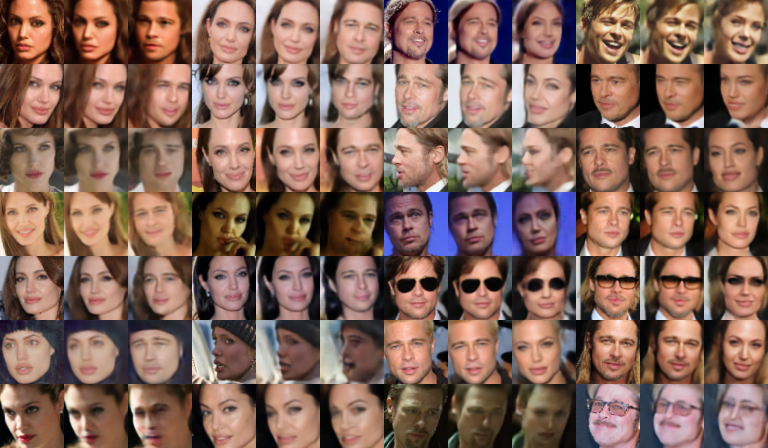

Epoch 20 A: 0.026495073 B: 0.026822548
Epoch 40 A: 0.02620048 B: 0.02608175
Epoch 60 A: 0.024819218 B: 0.026076239
Epoch 80 A: 0.024916979 B: 0.025465528
Epoch 100 A: 0.025883408 B: 0.025426757
save model weights


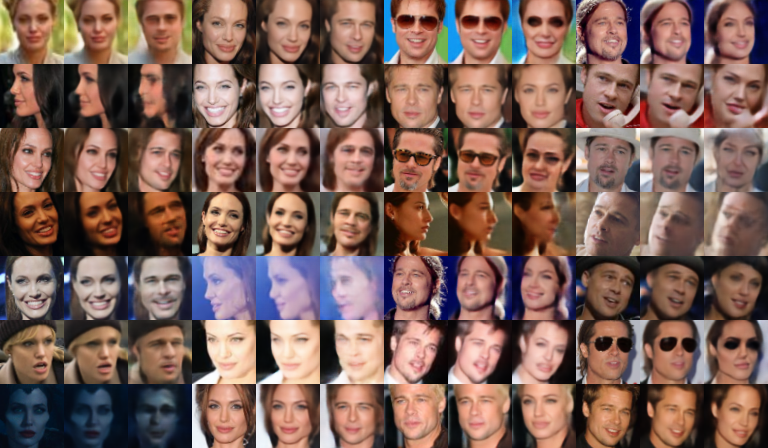

Epoch 120 A: 0.026135728 B: 0.02608744
Epoch 140 A: 0.026401546 B: 0.026184062
Epoch 160 A: 0.025257079 B: 0.025642661
Epoch 180 A: 0.025667392 B: 0.024931926
Epoch 200 A: 0.02477894 B: 0.025537137
save model weights


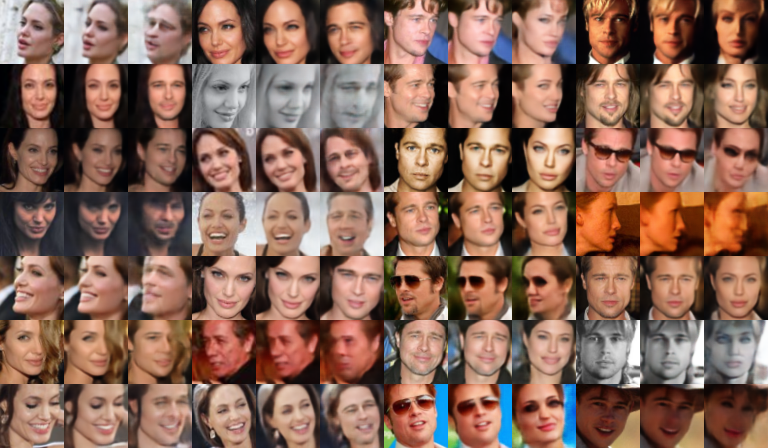

Epoch 220 A: 0.025712809 B: 0.024815302
Epoch 240 A: 0.025192253 B: 0.025481852
Epoch 260 A: 0.02531277 B: 0.026563361
Epoch 280 A: 0.024354478 B: 0.024734717


In [0]:
try:
    encoder.load_weights( "models/encoder.h5"   )
    decoder_A.load_weights( "models/decoder_A.h5" )
    decoder_B.load_weights( "models/decoder_B.h5" )
except:
    pass

def save_model_weights():
    encoder.save_weights( "models/encoder.h5"   )
    decoder_A.save_weights( "models/decoder_A.h5" )
    decoder_B.save_weights( "models/decoder_B.h5" )
    print( "save model weights" )

images_A = get_image_paths( "data/images/named_images/data/images/Angelina_Jolie/images/" )
images_B = get_image_paths( "data/images/named_images/data/images/Brad_Pitt/images/"  )
images_A = load_images( images_A ) / 255.0
images_B = load_images( images_B ) / 255.0

images_A += images_B.mean( axis=(0,1,2) ) - images_A.mean( axis=(0,1,2) )

print( "press 'q' to stop training and save model" )

for epoch in range(1000000):
    batch_size = 64
    warped_A, target_A = get_training_data( images_A, batch_size )
    warped_B, target_B = get_training_data( images_B, batch_size )

    loss_A = autoencoder_A.train_on_batch( warped_A, target_A )
    loss_B = autoencoder_B.train_on_batch( warped_B, target_B )
    
    if epoch % 20 == 0:
        print( "Epoch", epoch, "A:", loss_A, "B:", loss_B )

    if epoch % 100 == 0:
        save_model_weights()
        test_A = target_A[0:14]
        test_B = target_B[0:14]

    if epoch % 100 == 0:
        figure_A = numpy.stack([
            test_A,
            autoencoder_A.predict( test_A ),
            autoencoder_B.predict( test_A ),
            ], axis=1 )
        figure_B = numpy.stack([
            test_B,
            autoencoder_B.predict( test_B ),
            autoencoder_A.predict( test_B ),
            ], axis=1 )

        figure = numpy.concatenate( [ figure_A, figure_B ], axis=0 )
        figure = figure.reshape( (4,7) + figure.shape[1:] )
        figure = stack_images( figure )

        figure = numpy.clip( figure * 255, 0, 255 ).astype('uint8')

        cv2_imshow(figure)